<a href="https://colab.research.google.com/github/Baisakh-DS/ActivationFunctions/blob/main/Hybrid_AutoEncoder_with_VGG_for_Millet_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#This code is Giving Over fitting for SVM and Knn
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Datasets.zip', 'r')
zip_ref.extractall('/content/sample_data/Dataset')  # Extract to a folder
zip_ref.close()

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Function to add Gaussian noise
def add_gaussian_noise(image, mean=0, sigma=25):
    noise = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image

# Load images from folder, apply noise and labels
def load_images_from_folders(base_folder):
    images, labels = [], []
    label_names = ['BARNYARD', 'LITTLE MILLET', 'PROSO']
    label_map = {label: i for i, label in enumerate(label_names)}

    for label in label_names:
        label_folder = os.path.join(base_folder, label)
        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (128, 128))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = add_gaussian_noise(img)
                images.append(img)
                labels.append(label_map[label])
    return np.array(images), np.array(labels)

# Dataset path (modify if needed)
dataset_path = '/content/sample_data/Dataset/Datasets'
images, labels = load_images_from_folders(dataset_path)

# Preprocessing
images = images / 255.0
images = images.reshape(-1, 128, 128, 1)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Autoencoder
input_img = tf.keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.1)

# Encode images
encoder = models.Model(input_img, encoded)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Prepare for VGG19
X_train_encoded = np.repeat(X_train_encoded, 3, axis=-1)
X_test_encoded = np.repeat(X_test_encoded, 3, axis=-1)
input_shape = X_train_encoded.shape[1:]

# VGG19 as classifier
base_model = applications.VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(3, activation='softmax')(x)

hybrid_model = models.Model(inputs=base_model.input, outputs=output)
hybrid_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train hybrid model
history = hybrid_model.fit(X_train_encoded, y_train, epochs=10, validation_data=(X_test_encoded, y_test))

# Evaluation
y_pred = np.argmax(hybrid_model.predict(X_test_encoded), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f'Hybrid Model Accuracy: {accuracy:.2f}')

# Confusion Matrix
plt.figure(figsize=(5, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['BARNYARD', 'LITTLE MILLET', 'PROSO'], yticklabels=['BARNYARD', 'LITTLE MILLET', 'PROSO'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Accuracy Chart
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Classification Report
report = classification_report(y_test, y_pred, target_names=['BARNYARD', 'LITTLE MILLET', 'PROSO'])
print(report)


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 0.5458 - val_loss: 0.4614
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - loss: 0.4634 - val_loss: 0.4575
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 0.4601 - val_loss: 0.4525
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.4563 - val_loss: 0.4515
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.4534 - val_loss: 0.4510
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.4524 - val_loss: 0.4507
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.4530 - val_loss: 0.4504
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 0.4557 - val_loss: 0.4499
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.4525 - val_loss: 0.4493
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.4533 - val_loss: 0.4483
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step


ValueError: The input must have 3 channels; Received `input_shape=(32, 32, 48)`

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.5750 - val_loss: 0.4657
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.4663 - val_loss: 0.4582
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.4595 - val_loss: 0.4526
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - loss: 0.4540 - val_loss: 0.4518
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - loss: 0.4570 - val_loss: 0.4512
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.4538 - val_loss: 0.4509
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.4557 - val_loss: 0.4503
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.4530 - val_loss: 0.4495
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.4534 - val_loss: 0.4487
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 0.4509 - val_loss: 0.4481
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
Epoch 1/18
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 869ms/step - accuracy: 0.4005 - loss:

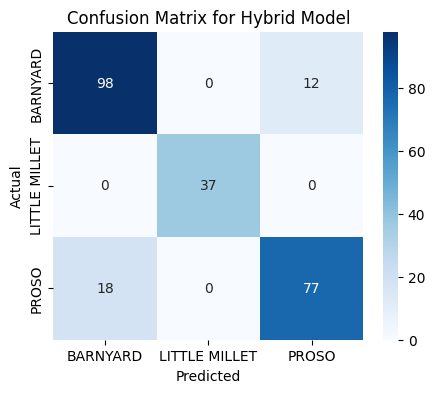

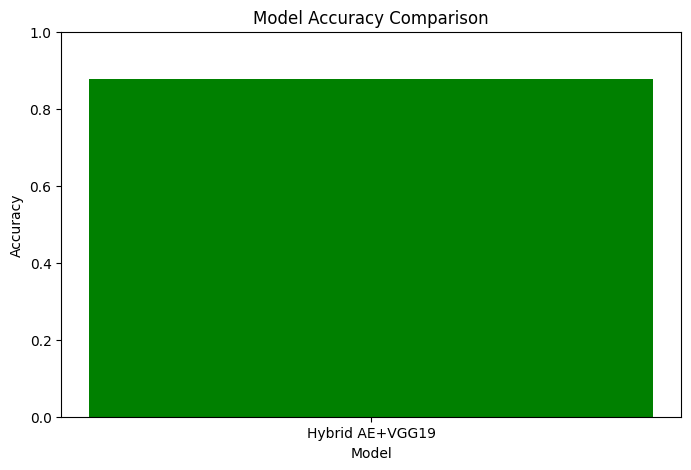

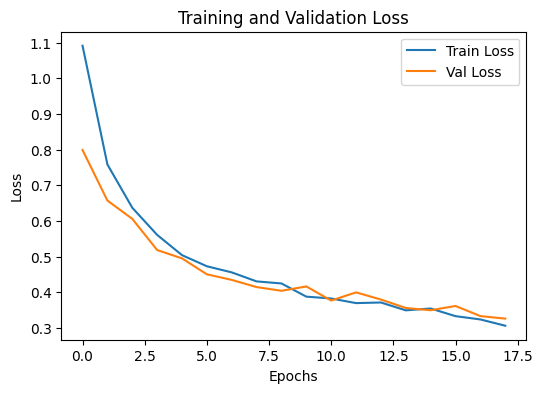

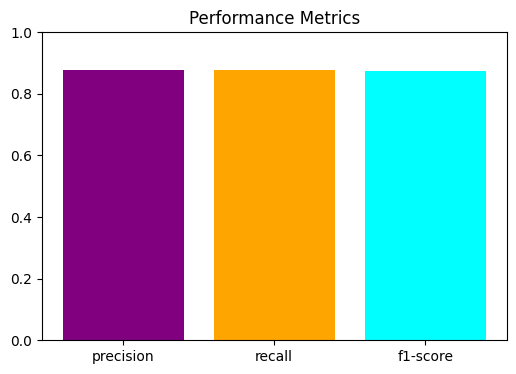

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# ------------------------ STEP 1: Load and Preprocess Dataset ------------------------

# Add Gaussian Noise
def add_gaussian_noise(image, mean=0, sigma=25):
    noise = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image

# Load images from folders and apply preprocessing
def load_images_from_folders(base_folder):
    images, labels = [], []
    label_names = ['BARNYARD', 'LITTLE MILLET', 'PROSO']
    label_map = {label: i for i, label in enumerate(label_names)}

    for label in label_names:
        folder = os.path.join(base_folder, label)
        if os.path.isdir(folder):
            for filename in os.listdir(folder):
                img_path = os.path.join(folder, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (128, 128))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = add_gaussian_noise(img)
                    images.append(img)
                    labels.append(label_map[label])

    return np.array(images), np.array(labels)

dataset_path = '/content/sample_data/Dataset/Datasets'  # Update this path
images, labels = load_images_from_folders(dataset_path)

images = images / 255.0  # Normalize
images = images.reshape(-1, 128, 128, 1)  # Add channel dimension

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# ------------------------ STEP 2: Build Autoencoder ------------------------

input_img = tf.keras.Input(shape=(128, 128, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

# Output of encoder to match VGG19 input (32x32x3)
encoded = layers.Conv2D(3, (3, 3), activation='relu', padding='same')(x)

# Decoder (optional)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Define models
autoencoder = models.Model(input_img, decoded)
encoder = models.Model(input_img, encoded)

# Compile and train autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.1)

# ------------------------ STEP 3: Encode Dataset ------------------------

X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# ------------------------ STEP 4: Build VGG19 Classifier ------------------------

# Load VGG19 without top
vgg = applications.VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in vgg.layers:
    layer.trainable = False

# Custom classifier on top
x = layers.Flatten()(vgg.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(3, activation='softmax')(x)

hybrid_model = models.Model(inputs=vgg.input, outputs=output)
hybrid_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train classifier
history = hybrid_model.fit(X_train_encoded, y_train, epochs=18, validation_data=(X_test_encoded, y_test))

# ------------------------ STEP 5: Evaluate Model ------------------------

y_pred = np.argmax(hybrid_model.predict(X_test_encoded), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f'Hybrid Model Accuracy: {accuracy:.2f}')

# Confusion Matrix
plt.figure(figsize=(5, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['BARNYARD', 'LITTLE MILLET', 'PROSO'], yticklabels=['BARNYARD', 'LITTLE MILLET', 'PROSO'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Hybrid Model')
plt.show()

# Accuracy Chart
plt.figure(figsize=(8, 5))
plt.bar(['Hybrid AE+VGG19'], [accuracy], color='green')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()

# Loss Graph
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Classification Report
report = classification_report(y_test, y_pred, target_names=['BARNYARD', 'LITTLE MILLET', 'PROSO'], output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
values = [report['weighted avg'][m] for m in metrics]

plt.figure(figsize=(6, 4))
plt.bar(metrics, values, color=['purple', 'orange', 'cyan'])
plt.title('Performance Metrics')
plt.ylim(0, 1)
plt.show()
